# First assignment - Andreas Samberg

Imports:

In [1300]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

from dstapi import DstApi
from fredapi import Fred
from helpers import f 

# Quick overview of the data

In [1301]:
PRIS113 = DstApi('PRIS113')
prices = PRIS113.get_data
PRIS113.tablesummary(language='en')


Table PRIS113: Consumer price index by type and time
Last update: 2025-10-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TYPE,1,INDEKS,Consumer price index,INDEKS,Consumer price index,False
1,Tid,549,1980M01,1980M01,2025M09,2025M09,True


In [1302]:
PRIS113.variable_levels('Tid',language='en')

,id,text
0,1980M01,1980M01
1,1980M02,1980M02
2,1980M03,1980M03
3,1980M04,1980M04
4,1980M05,1980M05
...,...,...
544,2025M05,2025M05
545,2025M06,2025M06
546,2025M07,2025M07
547,2025M08,2025M08


In [1303]:
def convert_prices_to_datetime():
    Y = pd.to_datetime(prices["TID"], format='%YM%m')
    return Y
Y
# Looks a litle weird but the number of observations is the same so i assume
# everything is fine.

0     1980-01-01
138   1980-02-01
276   1980-03-01
412   1980-04-01
1     1980-05-01
         ...    
532   2025-05-01
252   2025-06-01
132   2025-07-01
128   2025-08-01
275   2025-09-01
Name: TID, Length: 549, dtype: datetime64[ns]

I download the data:

In [1304]:
params = {
    'table': 'PRIS113',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'TYPE', 'values': ['*']},
        {'code': 'Tid', 'values': ['*']},
        ]
    }

# download
priser = PRIS113.get_data(params=params)


# display
display(priser.head())
display(priser.info())


,TYPE,TID,INDHOLD
0,Consumer price index,1980M02,33.3
1,Consumer price index,1980M06,34.6
2,Consumer price index,1980M10,35.8
3,Consumer price index,1981M02,36.8
4,Consumer price index,1981M06,39.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   TYPE     549 non-null    object
 1   TID      549 non-null    object
 2   INDHOLD  549 non-null    object
dtypes: object(3)
memory usage: 13.0+ KB


None

# The consumer price index (CPI), Pt, indexed to 100 on average in 2020


In [1305]:
# I transform 'INDHOLD' to numeric values

priser['INDHOLD'] = pd.to_numeric(priser['INDHOLD'])

# I take the mean of CPI in 2020
cpi_2020 = priser.loc[priser['TID'].str.contains('2020M'), 'INDHOLD'].mean()

print("Average CPI in 2020:", cpi_2020)

# make cpi_2020 equal to 100
priser['INDHOLD_rebased'] = priser['INDHOLD'] / cpi_2020 * 100


# Sort by date
priser = priser.sort_values("TID")
print(priser[["TID", "INDHOLD_rebased"]])


Average CPI in 2020: 103.43333333333332
         TID  INDHOLD_rebased
138  1980M01        31.904608
0    1980M02        32.194650
276  1980M03        32.678053
412  1980M04        32.871415
139  1980M05        33.354818
..       ...              ...
532  2025M05       116.403481
114  2025M06       116.693522
270  2025M07       118.433774
266  2025M08       117.660329
137  2025M09       117.563648

[549 rows x 2 columns]


In [1306]:
# I make sure that the average of 2020 is 100 and that all the observations are present
mask = priser['TID'].astype(str).str.contains('2020M')
print(priser.loc[mask, ['TID', 'INDHOLD_rebased']])
# The average:
average_2020 = priser.loc[mask, 'INDHOLD_rebased'].mean()
print("Average CPI in 2020 (normalized):", average_2020)

         TID  INDHOLD_rebased
521  2020M01        99.581051
256  2020M02       100.161134
545  2020M03        99.871092
118  2020M04        99.774412
399  2020M05        99.677731
536  2020M06        99.774412
263  2020M07       100.547857
248  2020M08       100.161134
125  2020M09       100.064454
393  2020M10       100.257815
541  2020M11       100.161134
400  2020M12        99.967773
Average CPI in 2020 (normalized): 100.0


# Figure with index 2020 = 100

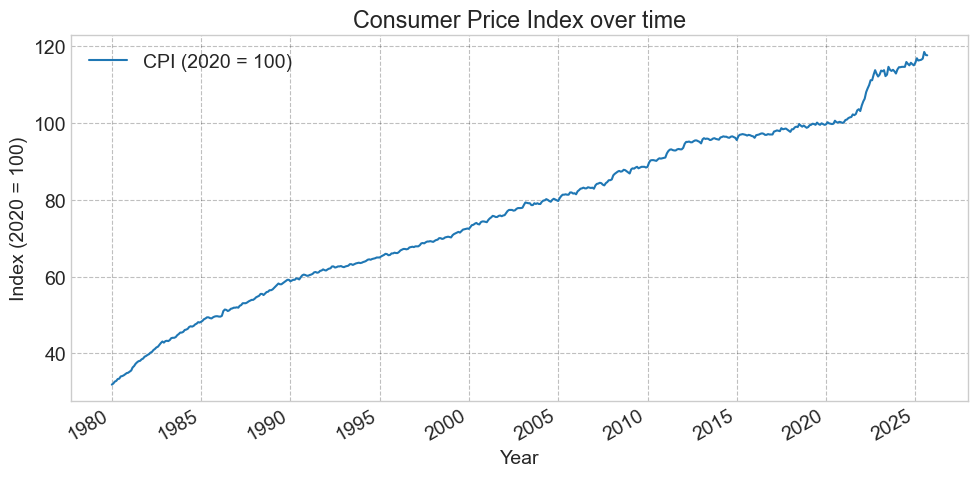

In [1307]:

# 1) Make a real datetime from 'TID' like "2020M01"
priser["date"] = pd.to_datetime(priser["TID"], format="%YM%m")

# 2) Sort (important for a clean line)
priser = priser.sort_values("date")

# 3) Plot using the datetime axis
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(priser["date"], priser["INDHOLD_rebased"], label="CPI (2020 = 100)")

ax.set_title("Consumer Price Index over time")
ax.set_xlabel("Year")
ax.set_ylabel("Index (2020 = 100)")

# 4) Control the x-axis ticks (show more years)
ax.xaxis.set_major_locator(mdates.YearLocator(5))         
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate()                                       

ax.legend()
plt.tight_layout()
plt.show()

# The month-to-month inflation rate

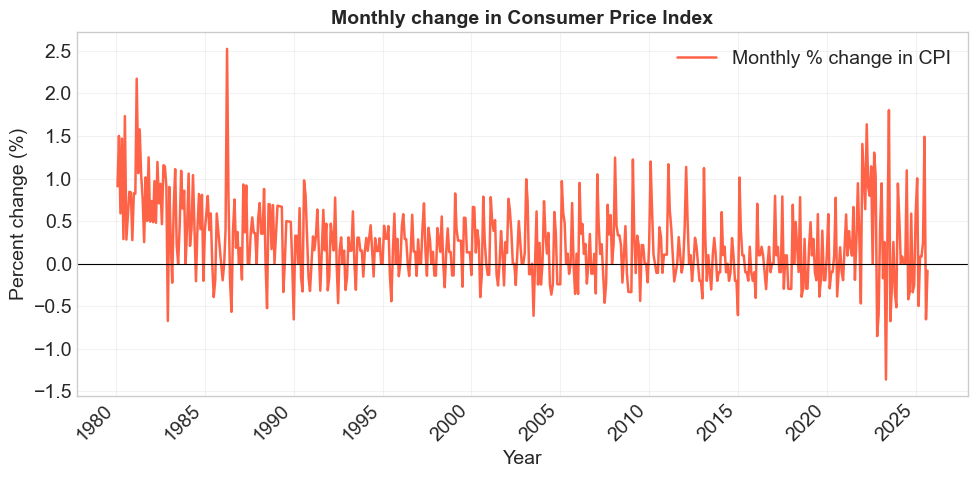

In [1308]:
priser = priser.sort_values("date")  # sortér kronologisk
priser["pct_change"] = priser["INDHOLD"].pct_change() * 100

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10,5))

plt.plot(priser["date"], priser["pct_change"], color="tomato", linewidth=1.8, label="Monthly % change in CPI")

plt.title("Monthly change in Consumer Price Index", fontsize=14, weight="bold")
plt.xlabel("Year")
plt.ylabel("Percent change (%)")

# Show ticks every year
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45, ha="right")

plt.axhline(0, color="black", linewidth=0.8)  # horizontal line at 0%
plt.legend()
plt.tight_layout()
plt.show()

# The 12-month inflation rate

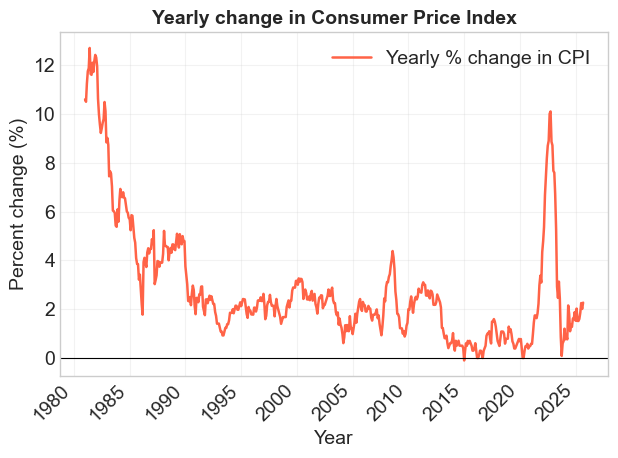

In [1309]:
priser["pct_change"] = priser["INDHOLD"].pct_change(12) * 100

plt.plot(priser["date"], priser["pct_change"], color="tomato", linewidth=1.8, label="Yearly % change in CPI")

plt.title("Yearly change in Consumer Price Index", fontsize=14, weight="bold")
plt.xlabel("Year")
plt.ylabel("Percent change (%)")

# Show ticks every year
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45, ha="right")

plt.axhline(0, color="black", linewidth=0.8)  # horizontal line at 0%
plt.legend()
plt.tight_layout()
plt.show()

# 1.2 Instantaneous inflation - 1.2.1

In [1310]:
# Since we are told that for a=0 we get the standard 12-month inflation rate, we can assume that T is = 12. 
T = 12
# Now that this parameter is defined, we can proceed to calculate kappa for different values of a and k.


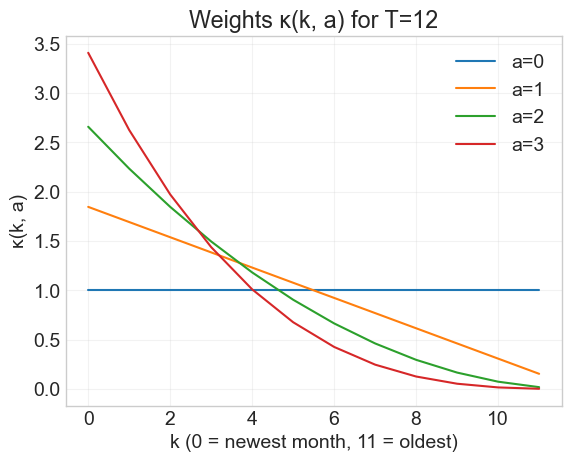

In [1311]:
# weights kappa(k,a)
def kappa(k, a):
  ks = np.arange(T)
  denom = np.sum((T - ks)**a)
  return ((T - k)**a / denom) * T

# plot kappa for a in {0,1,2,3}
k_vals = np.arange(T)
for a in [0, 1, 2, 3]:
    plt.plot(k_vals, [kappa(k, a) for k in k_vals], label=f'a={a}')
plt.xlabel('k (0 = newest month, 11 = oldest)')
plt.ylabel('κ(k, a)')
plt.title('Weights κ(k, a) for T=12')
plt.legend(); plt.grid(True); plt.show()

# instantaneous inflation
def instantaneous_inflation_last_window(pi_last_12, a, T=12):
    ks = np.arange(T)
    w = (T - ks)**a
    w = w / w.sum()
    return np.prod((1.0 + np.asarray(pi_last_12))**w) - 1

# Example
def instantaneous_inflation_series(pi_series, a, T=12):
    pi_series = np.asarray(pi_series)
    out = np.full(pi_series.shape, np.nan, dtype=float)
    ks = np.arange(T)
    w = (T - ks)**a; w = w / w.sum()
    for t in range(T-1, len(pi_series)):
        window = pi_series[t-T+1:t+1]      # Latest 12 months
        out[t] = np.prod((1.0 + window)**w) - 1
    return out

# 1.2.2 and 1.2.3

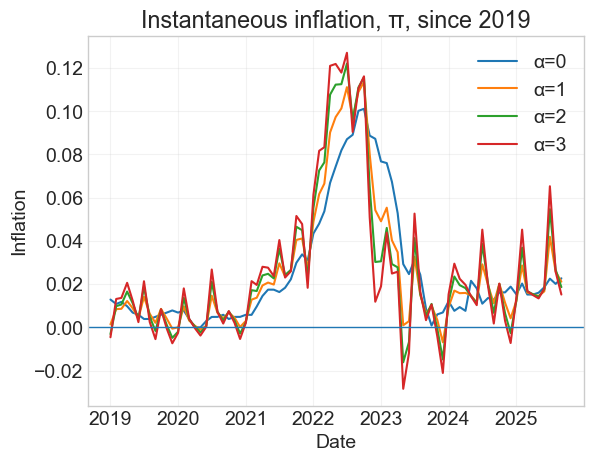

In [1312]:
# --- prep ---
priser = priser.sort_values('date').copy()
# monthly inflation: π_t = P_t/P_{t-1} - 1
priser['pi_t'] = priser['INDHOLD'].pct_change()


def kappa_weights(alpha, T=12):
    ks = np.arange(T)                   
    base = (T - ks)**alpha
    return (base / base.sum()) * T      


# The rolling method passes window as [oldest ... newest], but k=0 is newest,
# so we reverse the weights to align.
def inst_inflation_window(window, weights_rev):
    # window is a numpy array of length 12: oldest -> newest
    return np.prod((1.0 + window)**weights_rev) - 1

T = 12
alphas = [0, 1, 2, 3]
for a in alphas:
    w = kappa_weights(a, T=T)      
    w_rev = w[::-1]              
    col = f'pi12_a{a}'
    priser[col] = (
        priser['pi_t']
        .rolling(T)
        .apply(lambda x, wr=w_rev: inst_inflation_window(x, wr), raw=True)
    )

# plot since 2019
mask = priser['date'] >= pd.Timestamp('2019-01-01')
plt.figure()
for a in alphas:
    plt.plot(priser.loc[mask, 'date'], priser.loc[mask, f'pi12_a{a}'], label=f'α={a}')
plt.axhline(0, linewidth=1)
plt.title('Instantaneous inflation, π, since 2019')
plt.xlabel('Date'); plt.ylabel('Inflation')
plt.legend(); plt.grid(True)
plt.show()


# Semi conclusion to 1.2
We can also observe the standard yearly inflation rate from above but zoomed in freom 2019 and going forward:

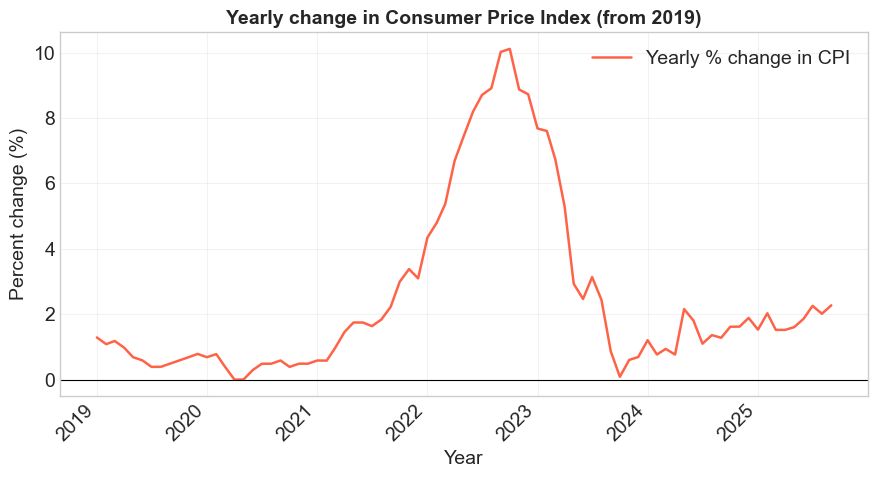

In [1313]:
# Make a new figure with only data from 2019 onward
mask = priser["date"] >= pd.Timestamp("2019-01-01")

plt.figure(figsize=(9,5))
plt.plot(
    priser.loc[mask, "date"],
    priser.loc[mask, "pct_change"],
    color="tomato",
    linewidth=1.8,
    label="Yearly % change in CPI"
)

plt.title("Yearly change in Consumer Price Index (from 2019)", fontsize=14, weight="bold")
plt.xlabel("Year")
plt.ylabel("Percent change (%)")

plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45, ha="right")

plt.axhline(0, color="black", linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()


# Full conclusion to 1.2
We can see that the standard yearly change in the CPI (which equals the instantaneous inflation for α = 0) reached its maximum later and was less severe, but it took longer to return to an inflation rate of zero. This is becuase the instantaneous inflation react quicker to changes.

# Core inflation 1.3

In [1314]:
# i Start by getting an overview of the dataset
PRIS111 = DstApi('PRIS111')
new_prices = PRIS111.get_data
PRIS111.tablesummary(language='en')

Table PRIS111: Consumer price index by commodity group, unit and time
Last update: 2025-10-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,VAREGR,385,000000,"00 Consumer price index, total",151000,15.1 Overall Consumer Price Index excl. energy,False
1,ENHED,3,100,Index,300,Percentage change compared to same month the y...,False
2,Tid,297,2001M01,2001M01,2025M09,2025M09,True


Overview for the variables in more detail

In [1315]:
PRIS111.variable_levels('ENHED',language='en')


,id,text
0,100,Index
1,200,Percentage change compared to previous month (...
2,300,Percentage change compared to same month the y...


In [1316]:
PRIS111.variable_levels('VAREGR',language='en')

,id,text
0,000000,"00 Consumer price index, total"
1,010000,01 Food and non-alcoholic beverages
2,011000,01.1 Food
3,011100,01.1.1 Bread and cereals
4,011110,01.1.1.1 Rice
...,...,...
380,127030,12.7.0.3 Funeral services
381,131000,13.1 Goods (total)
382,132000,13.2 Services (total)
383,141000,14.1 Overall Consumer Price Index - excl. ener...


In [1317]:
 # I am downloading the specific data I need from DST using the dstapi package.


params = {
    'table': 'PRIS111',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'ENHED', 'values': ['300']},
        {'code': 'VAREGR', 'values': ['000000', '151000', '141000']},
        {'code': 'Tid', 'values': ["*"]},
        ]
    }

# Download
new_prices = PRIS111.get_data(params=params)

# Only from 2019 and onwards
new_prices['date_1'] = pd.to_datetime(new_prices['TID'], format='%YM%m')
new_prices = new_prices[new_prices['date_1'].dt.year >= 2019]

# Sort by VAREGR and date
new_prices = new_prices.sort_values(by=["VAREGR", "date_1"]).reset_index(drop=True)


# Display
display(new_prices.head())


,ENHED,VAREGR,TID,INDHOLD,date_1
0,Percentage change compared to same month the y...,"00 Consumer price index, total",2019M01,1.3,2019-01-01
1,Percentage change compared to same month the y...,"00 Consumer price index, total",2019M02,1.1,2019-02-01
2,Percentage change compared to same month the y...,"00 Consumer price index, total",2019M03,1.2,2019-03-01
3,Percentage change compared to same month the y...,"00 Consumer price index, total",2019M04,1.0,2019-04-01
4,Percentage change compared to same month the y...,"00 Consumer price index, total",2019M05,0.7,2019-05-01


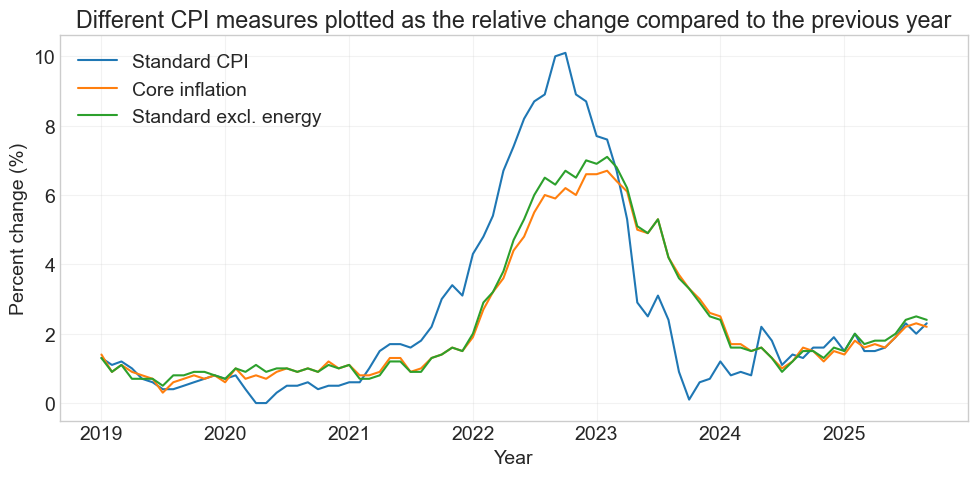

In [1318]:
# Create correct types - from text to dates floats
new_prices['date_1'] = pd.to_datetime(new_prices['date_1'], errors='coerce')
new_prices['INDHOLD'] = pd.to_numeric(new_prices['INDHOLD'], errors='coerce')




# I manually create the three groups in order to sort them correctly in the plot later on.
codes = ('00','14.1','15.1')
df_sel = new_prices[new_prices['VAREGR'].str.startswith(codes)].copy()


#Legend names:
L_names = {
    "00 Consumer price index, total": "Standard CPI",
    "14.1 Overall Consumer Price Index - excl. energy and unprocessed food (core inflation)": "Core inflation",
    "15.1 Overall Consumer Price Index excl. energy": "Standard excl. energy"
}


# Plot
plt.figure(figsize=(10,5))
for col in wide.columns:
    plt.plot(wide.index, wide[col], label=L_names.get(col, col))

plt.title("Different CPI measures plotted as the relative change compared to the previous year")
plt.xlabel("Year")
plt.ylabel("Percent change (%)")
plt.legend(loc='upper left')


# Nice x axis
ax = plt.gca()       
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y")) 
plt.tight_layout()
plt.show()


The figure gives a more detailed picture of what drove the post-pandemic inflation surge in Denmark. We can see that the core inflation and the standard CPI measuere excl. energi approximately followed the same path. Since the only difference between the standard CPI (the blue plot) and the standard CPI excl. energy (the green plot) we can conclude that the difference between them is due to high growth in energy prices. This is intresting becuase the development in the energi prices were concurrent with the invasion Ukaraine in 2022 which made EU sanction Russian oil and gas - driving prices up. So this implies that the high growth in the CPI due to covid were probably accelerated by the invasion of Ukraine becuase of the sanctions towards Russia.

# 1.4 Disaggregated inflation in Denmark

In [1319]:
# There must be a mistake in the assignment since table 113 is only the total CPI and not the varegr levels. Therefore it must be clear that the reference is to table 111. I assume this is what was meant.
# To begin with I copy the code from the assignment:
levels = DstApi('PRIS111').variable_levels('VAREGR',language='en' )
for row in levels.itertuples(): print(row.id,row.text)

000000 00 Consumer price index, total
010000 01 Food and non-alcoholic beverages
011000 01.1 Food
011100 01.1.1 Bread and cereals
011110 01.1.1.1 Rice
011120 01.1.1.2 Flours and other cereals
011130 01.1.1.3 Bread
011140 01.1.1.4 Other bakery products
011150 01.1.1.5 Pizza and quiche
011160 01.1.1.6 Pasta products and couscous
011170 01.1.1.7 Breakfast cereals
011180 01.1.1.8 Other cereal products
011200 01.1.2 Meat
011210 01.1.2.1 Beef and veal
011220 01.1.2.2 Pork
011230 01.1.2.3 Lamb and goat
011240 01.1.2.4 Poultry
011260 01.1.2.6 Edible offal
011270 01.1.2.7 Dried, salted or smoked meat
011280 01.1.2.8 Other meat preparations
011300 01.1.3 Fish and seafood
011310 01.1.3.1 Fresh or chilled fish
011320 01.1.3.2 Frozen fish
011340 01.1.3.4 Frozen seafood
011350 01.1.3.5 Dried, smoked or salted fish and seafood
011360 01.1.3.6 Other preserved or processed fish and seafood-based preparations
011400 01.1.4 Milk, cheese and eggs
011410 01.1.4.1 Milk, whole, fresh
011420 01.1.4.2 Milk, lo

In [1320]:
# keep only rows where the 'id' string contains at most two '0' characters
levels_filtered = levels[levels['id'].astype(str).str.count('0') <= 2].reset_index(drop=True)

display(levels_filtered)
print(f"Kept {len(levels_filtered)} rows (dropped {len(levels) - len(levels_filtered)} rows)")

,id,text
0,011110,01.1.1.1 Rice
1,011120,01.1.1.2 Flours and other cereals
2,011130,01.1.1.3 Bread
3,011140,01.1.1.4 Other bakery products
4,011150,01.1.1.5 Pizza and quiche
...,...,...
216,126210,12.6.2.1 Charges by banks etc.
217,126220,"12.6.2.2 Fees and service charges of brokers, ..."
218,127010,12.7.0.1 Administrative fees
219,127020,12.7.0.2 Legal services and accountancy


Kept 221 rows (dropped 164 rows)


In [1321]:
selected_codes = levels_filtered['id'].astype(str).tolist()

params_sel = {
    'table': 'PRIS111',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'ENHED', 'values': ['300']},
        {'code': 'VAREGR', 'values': selected_codes},
        {'code': 'Tid',   'values': ['*']},
    ]
}

new_new_prices = PRIS111.get_data(params=params_sel)
new_new_prices['date_2'] = pd.to_datetime(new_new_prices['TID'], format='%YM%m')

display(new_new_prices.tail())

,ENHED,VAREGR,TID,INDHOLD,date_2
65632,Percentage change compared to same month the y...,12.6.2.1 Charges by banks etc.,2024M03,6.5,2024-03-01
65633,Percentage change compared to same month the y...,"12.6.2.2 Fees and service charges of brokers, ...",2024M03,3.0,2024-03-01
65634,Percentage change compared to same month the y...,12.7.0.1 Administrative fees,2024M03,0.2,2024-03-01
65635,Percentage change compared to same month the y...,12.7.0.2 Legal services and accountancy,2024M03,2.0,2024-03-01
65636,Percentage change compared to same month the y...,12.7.0.3 Funeral services,2024M03,0.9,2024-03-01


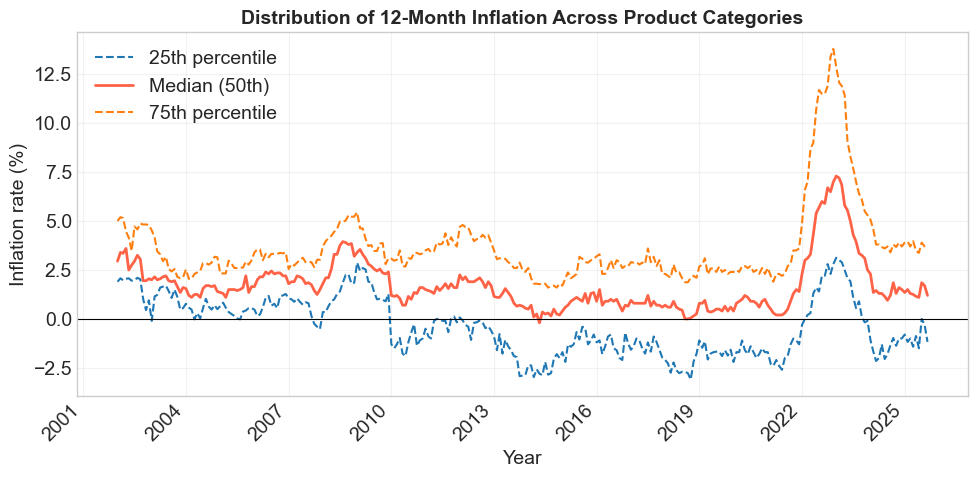

In [1322]:
# 2. The 12-month inflation rate for the 4-digit product categories


new_new_prices['INDHOLD'] = pd.to_numeric(new_new_prices['INDHOLD'], errors='coerce')
new_new_prices['date_2'] = pd.to_datetime(new_new_prices['TID'], format='%YM%m', errors='coerce')



percentiles = (
	new_new_prices
	.dropna(subset=['INDHOLD'])
	.groupby(date_col)['INDHOLD']
	.agg(q25=lambda x: x.quantile(0.25),
		 q50=lambda x: x.quantile(0.50),
		 q75=lambda x: x.quantile(0.75))
	.reset_index()
	.rename(columns={date_col: 'date_2'})
	.sort_values('date_2')
)

plt.figure(figsize=(10, 5))

plt.plot(percentiles["date_2"], percentiles["q25"], label="25th percentile", linestyle="--")
plt.plot(percentiles["date_2"], percentiles["q50"], label="Median (50th)", color="tomato", linewidth=2)
plt.plot(percentiles["date_2"], percentiles["q75"], label="75th percentile", linestyle="--")

plt.title("Distribution of 12-Month Inflation Across Product Categories", fontsize=14, weight="bold")
plt.xlabel("Year")
plt.ylabel("Inflation rate (%)")

# Format x-axis with yearly ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45, ha="right")

plt.axhline(0, color="black", linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()



We can see that there were a big jump in the inflation rate across most product categories around 2023. We see that all the categories jump compared to the year before as all the three catogories jump up at the same time. But we also see that 75 th percentile increased the distance between the 50th percentile and itself - implying that a few product catogories in in the highest end had a very high growth rate compared to the average growth rate.

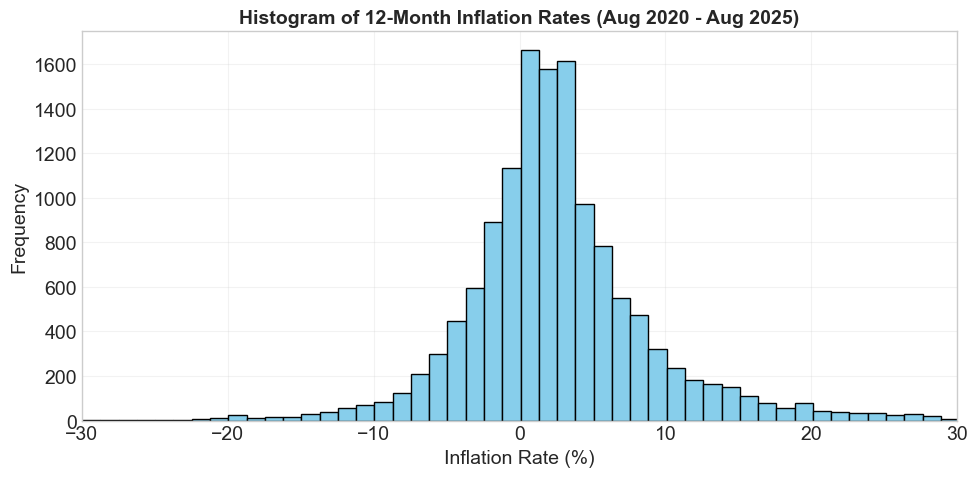

In [1323]:
# 3. plot since 2020-08-01
mask_2 = new_new_prices['date_2'] >= pd.Timestamp('2020-08-01')

vals = new_new_prices.loc[mask_2, 'INDHOLD'].dropna().astype(float)

plt.figure(figsize=(10, 5))
plt.hist(vals, bins=200, color='skyblue', edgecolor='black')
plt.title("Histogram of 12-Month Inflation Rates (Aug 2020 - Aug 2025)", fontsize=14, weight="bold")
plt.xlabel("Inflation Rate (%)")
plt.ylabel("Frequency")
plt.xlim(-30, 30)
plt.tight_layout()
plt.show()


We can observe that most observations had growth rates very close to, or slightly above, zero, implying that most product categories did not drive the large increase in inflation compared to previous years. The histogram is slightly right skewed implying that some catogories had huge growth and likely drove most of the inflation increase.

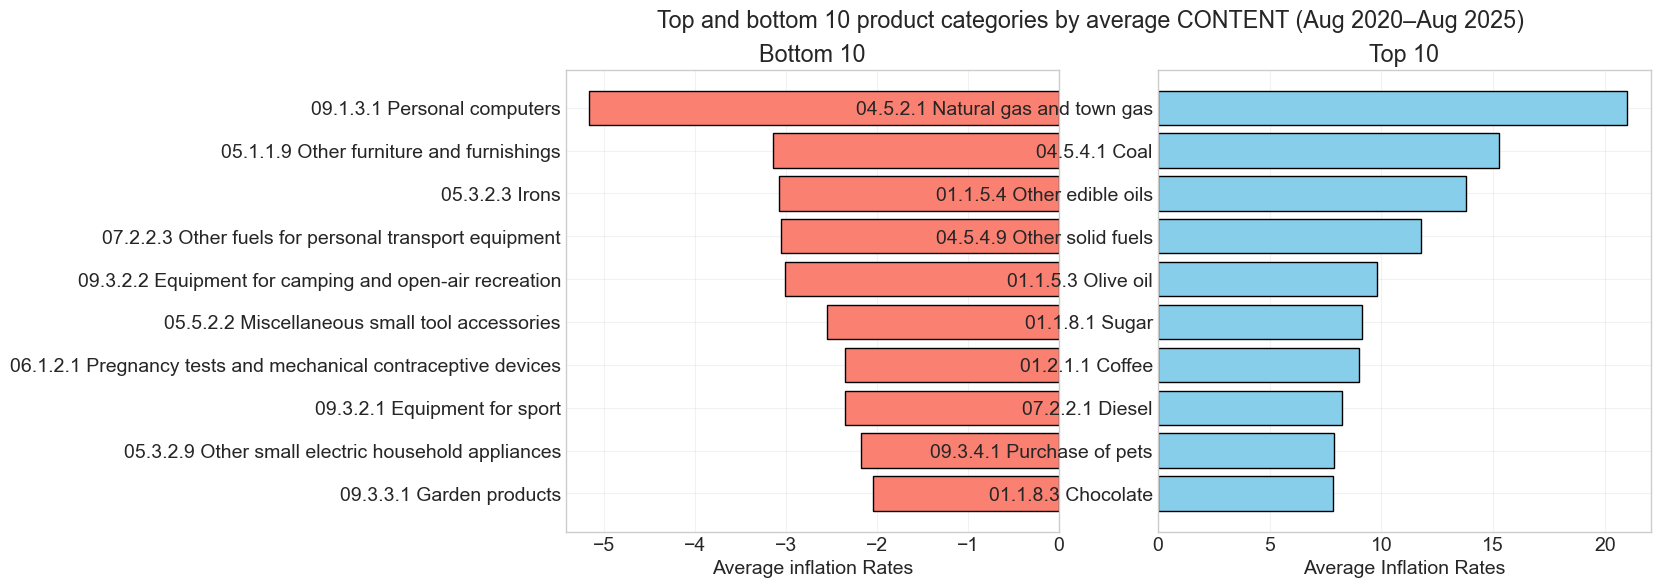

In [1324]:
# 4. Illustrate the top 10 and bottom 10 product categories

mask = (new_new_prices["date_2"] >= "2020-08-01") & (new_new_prices["date_2"] <= "2025-08-31")
subset = new_new_prices.loc[mask]

means = (
    subset
    .dropna(subset=['INDHOLD'])
    .groupby('VAREGR', as_index=True)['INDHOLD']
    .mean()
    .sort_values()
)

n = min(10, len(means))
bottom10 = means.head(n)
top10 = means.tail(n).sort_values(ascending=False)

# 4) Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False)

# Bottom 10
axes[0].barh(bottom10.index, bottom10.values, color='salmon', edgecolor='black')
axes[0].set_title("Bottom 10")
axes[0].set_xlabel("Average inflation Rates")
axes[0].invert_yaxis()

# Top 10 (now with highest on top)
axes[1].barh(top10.index, top10.values, color='skyblue', edgecolor='black')
axes[1].set_title("Top 10")
axes[1].set_xlabel("Average Inflation Rates")
axes[1].invert_yaxis() 

fig.suptitle(
    "Top and bottom 10 product categories by average CONTENT (Aug 2020–Aug 2025)",

)
plt.tight_layout
plt.show()



# 2 International Comparison

# 2.1 CPI vs HICP

In [1325]:
from fredapi import Fred
fred = Fred(api_key='a0296202584dd5a139ea9c89abc85c21')
series = fred.get_series("CP0000DKM086NEST")
data_fred = series.rename_axis('date').reset_index(name='value')
data_fred.head()

,date,value
0,1996-01-01,70.4
1,1996-02-01,70.8
2,1996-03-01,71.3
3,1996-04-01,71.5
4,1996-05-01,71.7


In [1326]:
PRIS113 = DstApi('PRIS113')
prices = PRIS113.get_data
PRIS113.tablesummary(language='en')


Table PRIS113: Consumer price index by type and time
Last update: 2025-10-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TYPE,1,INDEKS,Consumer price index,INDEKS,Consumer price index,False
1,Tid,549,1980M01,1980M01,2025M09,2025M09,True


In [1327]:

# Merge
merged = pd.merge(data_fred, new_new_prices, left_on='date', right_on='date_2', suffixes=('_hicp', '_cpi'))

# Plot
plt.figure(figsize=(10,5))
plt.plot(merged['date'], merged['value_hicp'], label='HICP (FRED, Eurostat)')
plt.plot(merged['date'], merged['value_cpi'], label='CPI (Danmarks Statistik)')
plt.title('Denmark: CPI vs HICP (2020 = 100)')
plt.xlabel('Year')
plt.ylabel('Index')
plt.legend()
plt.show()


KeyError: 'value_hicp'

<Figure size 1000x500 with 0 Axes>

# 2.2.